# Import Modules

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from skimage.io import imread_collection
import os
import glob
import cv2

from sklearn.neighbors import NearestCentroid
from skimage import measure
import skimage
from skimage.color import label2rgb

import heapq

# Load Data

In [2]:
# Set index of image for methodology visualizations
idx = 56

In [3]:
def data_loader():

    # Obtain folder
    folder = os.getcwd()
    folder2 = os.path.abspath(os.path.join(folder, os.pardir))
    
    # Load images
    img_paths = glob.glob(os.path.join(folder2+'\images', 'img_*.png'))
    img_paths = sorted(img_paths) 
    
    print('Loaded', len(img_paths), 'images.')

    # Load corner annotations
    data = pd.read_csv(folder2+'\images\corners.csv')
    corners = pd.DataFrame(data)
    
    
    corners.columns = ['img_name', 'x_top_left', 'y_top_left', 'x_top_right', 'y_top_right', 
                    'x_bottom_right', 'y_bottom_right', 'x_bottom_left', 'y_bottom_left']
    img_names = corners['img_name']
    corners.index = img_names
    
    
    corners = corners.iloc[: , 1:]
    
    # Set out of bound values
    corners[corners>=360] = 360
    corners[corners<0] = 0
    
    return img_paths, corners

def image_name(img_path):
    
        # Return image name from path
        head, tail = os.path.split(img_path)
        return tail
    
def xy_corners(img_path, corners):
    # Obtain array with corner coordinates
    img_name = image_name(img_path)
    
    img_corners = np.array(corners.loc[img_name])
    
    
    num_gates = len(img_corners)
   
    img_corners2 = []
    if len(img_corners.shape) > 1:
        for i,gate in enumerate(img_corners):
            gate2 = gate.reshape(4,2)
            img_corners2.append(gate2)
       
    else: 
        
        img_corners2 = img_corners.reshape(4,2)
    
        
    img_corners2 = np.array(img_corners2)
    
    return img_corners2


In [4]:
img_paths, corners_file = data_loader()

img_path = img_paths[idx]
corners_real = xy_corners(img_path, corners_file)

Loaded 308 images.


In [5]:
def get(X, show):
    hsv = cv2.cvtColor(X, cv2.COLOR_RGB2HSV)

    lower_blue = np.array([100,150,115])
    upper_blue = np.array([117,255,255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)    
    
    kernel_d0 = np.vstack([np.ones((3,3), np.uint8),
                           np.zeros((3,3), np.uint8)])
    
    kernel_e1 = np.vstack([np.ones((6, 25), np.uint8),
                          np.zeros((5, 25), np.uint8)]).T
    
    kernel_c1 =  np.vstack([-np.ones((1,51), np.uint8),
                            np.zeros((1,51), np.uint8),
                            np.ones((1,51), np.uint8)]).T
    kernel_c1_norm = np.prod(kernel_c1.shape)
    kernel_c1 = kernel_c1/kernel_c1_norm

    
    kernel_d1 = np.vstack([np.ones((6, 21), np.uint8),
                           np.zeros((5, 21), np.uint8)])
    
    # Fill white spaces in blue part of obstacles
    dilation0 = cv2.dilate(mask,kernel_d0,iterations = 1)
    
    # Remove noise / small blue pixels
    median1 = cv2.medianBlur(dilation0, 11)
    
    # Remove thin horizontal blue parts
    erosion1 = cv2.erode(median1,kernel_e1, iterations = 1)
    
    # Convolute to detect vertical blue areas
    convolution1 = cv2.filter2D(erosion1,-1,kernel_c1)
    convolution1[convolution1 >= 100] = 255
    convolution1[convolution1 < 100] = 0
    
    # Make the thin areas detected thicker to give them a higher 'weight'
    dilation1 = cv2.dilate(convolution1,kernel_d1,iterations = 1)
    img_test = dilation1
    
    # Obtain labels per segment
    label_image = measure.label(img_test)
    
    # Convert to RGB for plots
    image_labels = label2rgb(label_image, image=img_test, bg_label=0)    
    
    # Obtain the number of segments
    n_obj = np.max(label_image)

    # If there are more than two segments, than an obstacle is detected.
    if n_obj < 2:
        obstacle_detected = False
    else: 
        obstacle_detected  = True
   
    # Obstain all obstacle pixels and their segment label
    if obstacle_detected:
        points_lst = []
        label_lst = []

        for y, row in enumerate(label_image):
            for x, label_i in enumerate(row):
                if label_i != 0:
                    points_lst.append([x,y])
                    label_lst.append(label_i)
        label_lst = np.array(label_lst)
        
        # Find the centroid and labels of each segment
        if points_lst != []:
            
            NC_clf = NearestCentroid()
            NC_clf.fit(points_lst, label_lst)
            centers = NC_clf.centroids_   
            
            n_points_lst = []
    
            # Determine the size of each segment
            for i in range(n_obj):
                
                n_points = label_lst[label_lst==i+1].shape[0]
                n_points_lst.append(n_points)

            # Find the two largest segment areas
            max_idxs = heapq.nlargest(2, np.arange(len(n_points_lst)), key=n_points_lst.__getitem__)
            center1 = centers[max_idxs[0]]
            center2 = centers[max_idxs[1]]
            
            # Determine the difference in y-coordinates of the centers of the two largest segments
            diff =  np.abs(center1[1] - center2[1])
            
            # If this is too big, than probably the wrong segment was selected
            if diff > 30:
                y_values = centers[:,1]
                diff_min = 10000 

            # Then we try to find two segments that are vertically aligned
                for i in range(-1, n_obj-1):
                    y1 = y_values[i]
                    y2 = y_values[i+1]
                    diff = np.abs(y1-y2)

                    if diff < diff_min:
                        
                        center1 = centers[i]
                        center2 = centers[i+1]
                        diff_min = diff

            # Order the centers, center1 = left, center2 = right
            if center1[0] > center2[0]:
                temp = center1
                center1 = center2
                center2 = temp

            centers = np.array([center1, center2])

            # Store the coordinates of the centers
            c1x = center1[0]
            c2x = center2[0]
            c1y = center1[1]
            c2y = center2[1]

            # Determine the vector from the left to the right center
            dx = (c2x - c1x)/2
            dy = (c2y -c1y)/2

            # Compute the location of the corner points
            bottom_left = [c1x - dy, c1y + dx]
            top_left = [c1x + dy, c1y - dx]
            bottom_right = [c2x - dy, c2y + dx]
            top_right = [c2x + dy, c2y - dx]

            corners = np.array([top_left, top_right, bottom_right, bottom_left] )
    
    # If no obstacles are detected, it is just an empty array
    else:
        corners = np.array([])
        centers = np.array([])
        
        
    if show:
        plt.rcParams["figure.figsize"] = (10, 10)
        
        ax1 = plt.subplot(3, 3, 1)
        ax1.title.set_text('Original image')
        plt.imshow(X)
        plt.axis('off')
        
        ax2 = plt.subplot(3, 3, 2)
        ax2.title.set_text('Mask Blue')
        plt.imshow(mask)
        plt.axis('off')
        
        ax3 = plt.subplot(3, 3, 3)
        ax3.title.set_text('Dilation 1')
        plt.imshow(dilation0)
        plt.axis('off')
        
        ax4 = plt.subplot(3, 3, 4)
        ax4.title.set_text('Median Filter')
        plt.imshow(median1)
        plt.axis('off')
        
        ax5 = plt.subplot(3, 3, 5)
        ax5.title.set_text('Erosion')
        plt.imshow(erosion1)
        plt.axis('off')
  
        ax6 = plt.subplot(3, 3, 6)
        ax6.title.set_text('Convolution')
        plt.imshow(convolution1)
        plt.axis('off')
        
        
        ax7 = plt.subplot(3, 3 ,7)
        ax7.title.set_text('Labels')
        plt.imshow(image_labels)
        plt.axis('off')
        
        ax8 = plt.subplot(3, 3 ,8)
        ax8.title.set_text('Mean')
        plt.scatter(centers[:,0], centers[:,1])
        plt.imshow(image_labels)
        plt.axis('off')
        
        ax9 = plt.subplot(3, 3 ,9)
        ax9.title.set_text('Corners')
        plt.scatter(corners[:,0], corners[:,1], c = 'r', s = 200)
        plt.imshow(X)
        plt.axis('off')
        
        plt.show()

    return corners, centers, image_labels, obstacle_detected


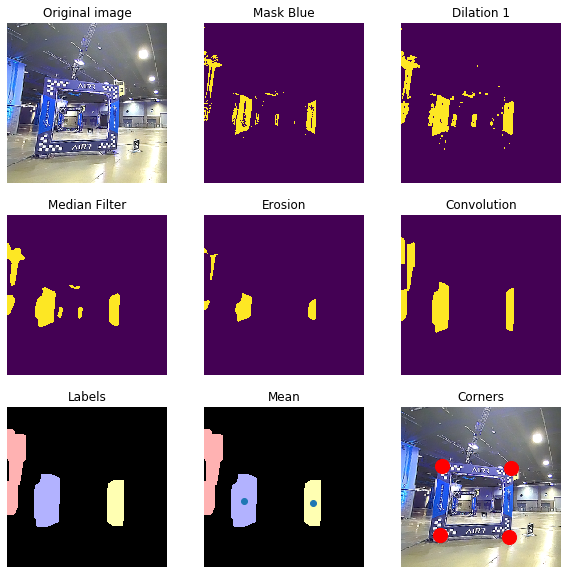

Wall time: 955 ms


In [6]:
%%time
X = skimage.io.imread(img_path) 
corners_pred, centers, img_test, obstacle_detected = get(X, True)


In [7]:
def comp_dist(img_corners):
    corner1 = img_corners[0]  # Top left
    corner2 = img_corners[1]  # Top right
    
    # Compute distance between top corners
    dist = np.sqrt(np.sum((corner1 - corner2)**2))
    
    return dist

def nearest_obstacle(img_corners_all):
    
    # Out of all obstacles in an image, find the nearest gate
    distlst = []
    
    # Check if there is more than one gate
    if np.prod(np.array(img_corners_all).shape) > 8:
        for i, img_corners in enumerate(img_corners_all):
            dist = comp_dist(img_corners)
            distlst.append(dist)
            
        # This is the gate with the largest distance between its top corners
        nearest_obst_idx = distlst.index(max(distlst))
        return img_corners_all[nearest_obst_idx]
                               
    else:
        # If there is only one gate, just return its corners
        return img_corners_all
    

def correct_predicted(corners_real_all, corners_pred):
    
    # Based on the distance between the predicted corners and the real corners, determine if the obstacle is correctly predicted.
    corners_real = nearest_obstacle(corners_real_all)
    diff = None 
    
    if corners_pred.shape != (0,):
        
        diff = np.sqrt(np.sum(np.power((corners_real - corners_pred),4)))
        if diff < 5000:
            correct_predicted = 1
            
        else:
            correct_predicted = 0
    if diff == None:
        diff = 999999
        correct_predicted = 0
        
    return correct_predicted, diff
    

In [8]:
# Set plot size
plt.rcParams["figure.figsize"] = (10, 10)
plt.tight_layout()

folder = str(os.getcwd())
a =  str(folder+'\\perf_evaluation\\')
if not os.path.exists(a):
        os.makedirs(a)
acc = 0

for i in range(0, len(img_paths)):
    # Obtain image
    img_path = img_paths[i]
    img_name = image_name(img_path)
    X = skimage.io.imread(img_path) 
    
    # Predict corners
    corners_real = xy_corners(img_path, corners_file)
    corners_pred, centers, img_test, obstacle_detected = get(X, False)
    success, diff = correct_predicted(corners_real, corners_pred)
    
    # Plot corners
    if obstacle_detected:
        plt.scatter(corners_pred[:,0], corners_pred[:,1], c = 'r', s = 500)
    plt.imshow(X)
    plt.axis('off')
    
    # Label it based on correct prediction
    if success:
         k = str('T_')
    else: 
        k = str('F_')
    
    # Save image
    b =  str(a+k+'_'+str(i)+img_name)
    plt.savefig(b, bbox_inches='tight',pad_inches = 0)
    plt.close()
   
    # Print progress
    if i % 15 == 0 and i != 0:
        print(' ', int(i / len(img_paths) * 100), '%')
    elif i == 0:
        print('Start Processing')
    else:
        print("=",  end = '')
        
    acc += success

print('     100%')

print( '\n')
print( '******************************************************')
print('Predicted ', acc, ' out of', len(img_paths), 'nearest obstacles correctly. \n')
print('Accuracy:', np.round(acc/(len(img_paths)), 3 ) )
print( '******************************************************')


Start Processing
==============  4 %
==============  9 %
==============  14 %
==============  19 %
==============  24 %
==============  29 %
==============  34 %
==============  38 %
==============  43 %
==============  48 %
==============  53 %
==============  58 %
==============  63 %
==============  68 %
==============  73 %
==============  77 %
==============  82 %
==============  87 %
==============  92 %
==============  97 %
=======     100%


******************************************************
Predicted  265  out of 308 nearest obstacles correctly. 

Accuracy: 0.86
******************************************************
